<a href="https://colab.research.google.com/github/nananana25/MSC151/blob/main/CW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# main.py


import pulp as pl
from collections import defaultdict
import os
import csv

# ----------------------------
# DATA (matches CW5 PDF)
# ----------------------------
baristas = ["Max", "Jiwa", "Fore", "Donna", "Paul"]
days = list(range(1, 8))      # 1..7 (Mon..Sun)
blocks = list(range(1, 5))    # 1..4 (each = 4-hour block)
H = 4                         # hours per block

cost = {"Max": 50000, "Jiwa": 50000, "Fore": 50000, "Donna": 150000, "Paul": 150000}
etype = {"Max": "P", "Jiwa": "P", "Fore": "P", "Donna": "F", "Paul": "F"}
minWeekly_default = {"Max": 12, "Jiwa": 12, "Fore": 12, "Donna": 36, "Paul": 36}

# availability a_{o,d} as per table in CW5
avail = {
    ("Max", 1): 8,  ("Max", 2): 8,  ("Max", 3): 8,  ("Max", 4): 0,  ("Max", 5): 8,  ("Max", 6): 4,  ("Max", 7): 4,
    ("Jiwa", 1): 4, ("Jiwa", 2): 4, ("Jiwa", 3): 8, ("Jiwa", 4): 8, ("Jiwa", 5): 0, ("Jiwa", 6): 4, ("Jiwa", 7): 0,
    ("Fore", 1): 8, ("Fore", 2): 0, ("Fore", 3): 8, ("Fore", 4): 8, ("Fore", 5): 8, ("Fore", 6): 8, ("Fore", 7): 0,
    ("Donna", 1): 12, ("Donna", 2): 12, ("Donna", 3): 12, ("Donna", 4): 12, ("Donna", 5): 12, ("Donna", 6): 12, ("Donna", 7): 8,
    ("Paul", 1): 12, ("Paul", 2): 8,  ("Paul", 3): 12, ("Paul", 4): 12, ("Paul", 5): 8,  ("Paul", 6): 12, ("Paul", 7): 12,
}

DAY_NAME = {1: "Mon", 2: "Tue", 3: "Wed", 4: "Thu", 5: "Fri", 6: "Sat", 7: "Sun"}
BLOCK_NAME = {1: "07:00–11:00", 2: "11:00–15:00", 3: "15:00–19:00", 4: "19:00–23:00"}

# reference to uploaded coursework pdf (local path)
CW5_PDF_PATH = "/mnt/data/CW5_MSCI151_released.pdf"


# ----------------------------
# Helper functions
# ----------------------------
def build_staffing_model(baristas, days, blocks, H, cost, avail, etype, minWeekly, allow_blocks=None, name="Staffing", sense=pl.LpMinimize):
    """
    Build baseline staffing model (flat keys y[(o,d,b)]).
    """
    model = pl.LpProblem(name, sense)

    if allow_blocks is None:
        allow_blocks = {d: set(blocks) for d in days}
    else:
        allow_blocks = {d: set(bs) for d, bs in allow_blocks.items()}

    # Decision variables
    y = pl.LpVariable.dicts(
        "y",
        [(o, d, b) for o in baristas for d in days for b in allow_blocks[d]],
        lowBound=0, upBound=1, cat="Binary"
    )

    # Objective: minimize total weekly cost
    model += pl.lpSum(H * cost[o] * y[(o, d, b)] for o in baristas for d in days for b in allow_blocks[d]), "TotalCost"

    # 1) Coverage: at least one barista in every allowed block/day
    for d in days:
        for b in allow_blocks[d]:
            model += pl.lpSum(y[(o, d, b)] for o in baristas) >= 1, f"cover_d{d}_b{b}"

    # 2) Per-day availability (hours) and contractual block caps
    for o in baristas:
        for d in days:
            # availability limit
            model += H * pl.lpSum(y[(o, d, b)] for b in allow_blocks[d]) <= avail[(o, d)], f"avail_{o}_{d}"
            # contractual daily block cap
            cap = 2 if etype[o] == "P" else 3
            model += pl.lpSum(y[(o, d, b)] for b in allow_blocks[d]) <= cap, f"blockCap_{o}_{d}"

    # 4) Weekly minimum hours
    for o in baristas:
        model += H * pl.lpSum(y[(o, d, b)] for d in days for b in allow_blocks[d]) >= minWeekly[o], f"weeklyMin_{o}"

    return model, y, allow_blocks


def extract_results(model, y, baristas, days, blocks, allow_blocks, H):
    """
    Extract solver status, objective, hours per barista, and schedule (daily x block).
    """
    status = pl.LpStatus[model.status]
    total_cost = pl.value(model.objective)

    hours_by_barista = {o: 0 for o in baristas}
    schedule = defaultdict(lambda: defaultdict(list))  # schedule[d][b] -> list of baristas

    for o in baristas:
        for d in days:
            for b in allow_blocks[d]:
                val = y[(o, d, b)].value()
                if val is not None and val > 0.5:
                    hours_by_barista[o] += H
                    schedule[d][b].append(o)

    return status, total_cost, hours_by_barista, schedule


def print_summary(title, status, total_cost, hours_by_barista, schedule):
    print("\n" + "=" * 72)
    print(title)
    print("=" * 72)
    print(f"Solver status: {status}")
    if total_cost is not None:
        print(f"Total weekly cost (IDR): {int(total_cost):,}")
    print("\nWeekly hours per barista:")
    for o in hours_by_barista:
        print(f"  - {o:6s}: {hours_by_barista[o]:2d} hours")

    print("\nDaily × Block schedule:")
    for d in sorted(schedule.keys()):
        print(f"  {DAY_NAME[d]}:")
        for b in sorted(schedule[d].keys()):
            who = ", ".join(schedule[d][b]) if schedule[d][b] else "(none)"
            print(f"    [{BLOCK_NAME[b]}] → {who}")
    print("=" * 72 + "\n")


def save_schedule_csv(filename, hours_by_barista, schedule, days, blocks):
    """
    Save summary CSV with two parts: hours per barista and daily schedule table.
    """
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["--- Weekly hours per barista ---"])
        writer.writerow(["Barista", "Hours"])
        for o, hrs in hours_by_barista.items():
            writer.writerow([o, hrs])
        writer.writerow([])
        writer.writerow(["--- Daily schedule ---"])
        header = ["Day/Block"] + [BLOCK_NAME[b] for b in blocks]
        writer.writerow(header)
        for d in days:
            row = [DAY_NAME[d]]
            for b in blocks:
                names = schedule.get(d, {}).get(b, [])
                row.append(";".join(names) if names else "")
            writer.writerow(row)


# ----------------------------
# Fairness model builder
# ----------------------------
def build_fairness_model(baristas, days, blocks, H, cost, avail, etype, minWeekly, baseline_cost, allow_blocks=None, name="Fairness"):
    """
    Build fairness MILP:
    - minimize Hmax - Hmin
    - subject to coverage, availability, contractual caps, weekly minima
    - plus budget cap: total_cost <= 1.02 * baseline_cost
    Uses flat y[(o,d,b)] variables.
    """
    model = pl.LpProblem(name, pl.LpMinimize)

    if allow_blocks is None:
        allow_blocks = {d: set(blocks) for d in days}
    else:
        allow_blocks = {d: set(bs) for d, bs in allow_blocks.items()}

    # Binary assignment vars
    y = pl.LpVariable.dicts("y", [(o, d, b) for o in baristas for d in days for b in allow_blocks[d]], lowBound=0, upBound=1, cat="Binary")

    # Continuous hours vars and extrema
    hours_o = pl.LpVariable.dicts("hours", baristas, lowBound=0, cat="Continuous")
    Hmax = pl.LpVariable("Hmax", lowBound=0, cat="Continuous")
    Hmin = pl.LpVariable("Hmin", lowBound=0, cat="Continuous")

    # Objective: minimize gap
    model += Hmax - Hmin, "FairnessGap"

    # Coverage
    for d in days:
        for b in allow_blocks[d]:
            model += pl.lpSum(y[(o, d, b)] for o in baristas) >= 1, f"cover_d{d}_b{b}"

    # Daily availability and block caps
    for o in baristas:
        for d in days:
            model += H * pl.lpSum(y[(o, d, b)] for b in allow_blocks[d]) <= avail[(o, d)], f"avail_{o}_{d}"
            cap = 2 if etype[o] == "P" else 3
            model += pl.lpSum(y[(o, d, b)] for b in allow_blocks[d]) <= cap, f"blockCap_{o}_{d}"

    # Weekly minima
    for o in baristas:
        model += H * pl.lpSum(y[(o, d, b)] for d in days for b in allow_blocks[d]) >= minWeekly[o], f"weeklyMin_{o}"

    # Link hours_o and bound to Hmax/Hmin
    for o in baristas:
        model += hours_o[o] == H * pl.lpSum(y[(o, d, b)] for d in days for b in allow_blocks[d]), f"hours_link_{o}"
        model += hours_o[o] <= Hmax, f"leq_Hmax_{o}"
        model += hours_o[o] >= Hmin, f"geq_Hmin_{o}"

    # Budget cap (≤ 1.02 * baseline_cost)
    total_cost = pl.lpSum(H * cost[o] * y[(o, d, b)] for o in baristas for d in days for b in allow_blocks[d])
    model += total_cost <= 1.02 * baseline_cost, "budget_cap"

    return model, y, allow_blocks


# ----------------------------
# Scenario runners
# ----------------------------
def solve_baseline():
    model, y, allow_blocks = build_staffing_model(
        baristas, days, blocks, H, cost, avail, etype, minWeekly_default, name="Baseline"
    )
    solver = pl.PULP_CBC_CMD(msg=True, timeLimit=300)  # 5 min
    model.solve(solver)
    return model, extract_results(model, y, baristas, days, blocks, allow_blocks, H)


def solve_close_at_19():
    allow_blocks = {d: {1, 2, 3} for d in days}
    model, y, allow_blocks = build_staffing_model(
        baristas, days, blocks, H, cost, avail, etype, minWeekly_default, allow_blocks=allow_blocks, name="CloseAt19"
    )
    solver = pl.PULP_CBC_CMD(msg=True, timeLimit=300)
    model.solve(solver)
    return model, extract_results(model, y, baristas, days, blocks, allow_blocks, H)


def solve_pt_min16():
    minWeekly_pt16 = {o: (16 if etype[o] == "P" else 36) for o in baristas}
    model, y, allow_blocks = build_staffing_model(
        baristas, days, blocks, H, cost, avail, etype, minWeekly_pt16, name="PTMin16"
    )
    solver = pl.PULP_CBC_CMD(msg=True, timeLimit=300)
    model.solve(solver)
    return model, extract_results(model, y, baristas, days, blocks, allow_blocks, H)


def solve_fairness(baseline_cost):
    model, y, allow_blocks = build_fairness_model(
        baristas, days, blocks, H, cost, avail, etype, minWeekly_default, baseline_cost, name="Fairness"
    )
    solver = pl.PULP_CBC_CMD(msg=True, timeLimit=300)
    model.solve(solver)
    return model, extract_results(model, y, baristas, days, blocks, allow_blocks, H)



# ----------------------------
# Main execution
# ----------------------------
def main():
    print("CW5 MILP models using PuLP (CBC).")

    # Baseline
    baseline_model, (status_base, base_cost, base_hours, base_sched) = solve_baseline()
    print_summary("BASELINE (open 07:00–23:00)", status_base, base_cost, base_hours, base_sched)
    save_schedule_csv("results/baseline_schedule.csv", base_hours, base_sched, days, blocks)

    # Scenario A: close at 19:00 (remove block 4)
    sA_model, (status_sA, sA_cost, sA_hours, sA_sched) = solve_close_at_19()
    print_summary("SCENARIO A — CLOSE AT 19:00 (remove block 4)", status_sA, sA_cost, sA_hours, sA_sched)
    save_schedule_csv("results/close19_schedule.csv", sA_hours, sA_sched, days, [1, 2, 3])  # only 3 blocks

    # Scenario B: part-time weekly minimum = 16 hours
    sB_model, (status_sB, sB_cost, sB_hours, sB_sched) = solve_pt_min16()
    print_summary("SCENARIO B — PART-TIME MIN = 16 HOURS", status_sB, sB_cost, sB_hours, sB_sched)
    save_schedule_csv("results/ptmin16_schedule.csv", sB_hours, sB_sched, days, blocks)

    # Fairness model (≤ 102% of baseline cost)
    fairness_model, (status_fair, fair_cost, fair_hours, fair_sched) = solve_fairness(base_cost)
    print_summary("FAIRNESS VARIANT (minimize Hmax-Hmin; cost ≤ 102% of baseline)", status_fair, fair_cost, fair_hours, fair_sched)
    save_schedule_csv("results/fairness_schedule.csv", fair_hours, fair_sched, days, blocks)

    # Quick cost summary printed
    print("--- COST SUMMARY (IDR) ---")
    print(f"Baseline:  {int(base_cost):,} (status: {status_base})")
    print(f"Close@19:  {int(sA_cost):,} (status: {status_sA})")
    print(f"PT min16:  {int(sB_cost):,} (status: {status_sB})")
    print(f"Fairness:  {int(fair_cost):,} (status: {status_fair})")
    print("--------------------------\n")

    # remind user of CW5 pdf path for report
    print("Coursework PDF (for your report / README):", CW5_PDF_PATH)


if __name__ == "__main__":
    main()


CW5 MILP models using PuLP (CBC).

BASELINE (open 07:00–23:00)
Solver status: Optimal
Total weekly cost (IDR): 12,800,000

Weekly hours per barista:
  - Max   : 12 hours
  - Jiwa  : 12 hours
  - Fore  : 16 hours
  - Donna : 36 hours
  - Paul  : 36 hours

Daily × Block schedule:
  Mon:
    [07:00–11:00] → Donna
    [11:00–15:00] → Paul
    [15:00–19:00] → Max
    [19:00–23:00] → Jiwa
  Tue:
    [07:00–11:00] → Donna
    [11:00–15:00] → Donna
    [15:00–19:00] → Jiwa
    [19:00–23:00] → Max
  Wed:
    [07:00–11:00] → Paul
    [11:00–15:00] → Fore
    [15:00–19:00] → Fore
    [19:00–23:00] → Paul
  Thu:
    [07:00–11:00] → Donna
    [11:00–15:00] → Paul
    [15:00–19:00] → Donna
    [19:00–23:00] → Paul
  Fri:
    [07:00–11:00] → Paul
    [11:00–15:00] → Fore
    [15:00–19:00] → Fore
    [19:00–23:00] → Paul
  Sat:
    [07:00–11:00] → Donna
    [11:00–15:00] → Jiwa
    [15:00–19:00] → Donna
    [19:00–23:00] → Max
  Sun:
    [07:00–11:00] → Paul
    [11:00–15:00] → Donna
    [15:00–19:00]

Data Visualization

/tmp/ipython-input-1968101567.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Scenario', y='Cost (IDR)', data=df_scenario_costs, palette='magma')


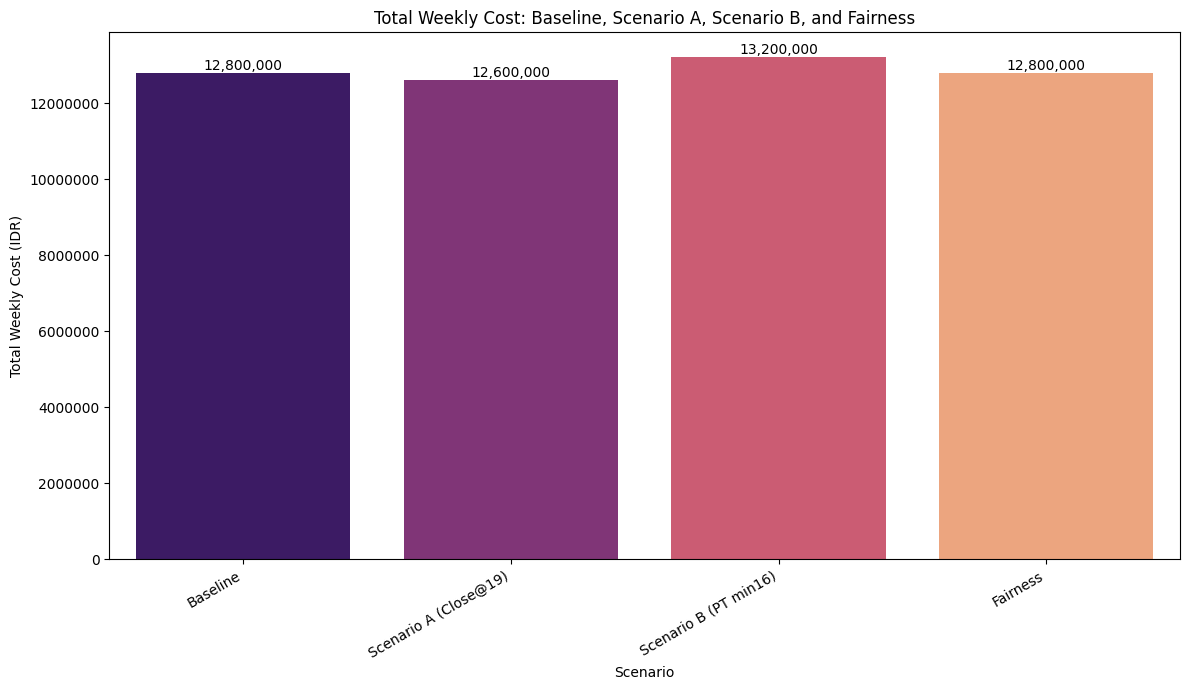

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data extracted from previous execution outputs and kernel state
costs_specific_scenarios = {
    'Scenario': [
        'Baseline',
        'Scenario A (Close@19)',
        'Scenario B (PT min16)',
        'Fairness'
    ],
    'Cost (IDR)': [
        12800000,   # baseline_cost
        12600000,   # sA_cost
        13200000,   # sB_cost
        12800000    # Fairness (using baseline cost as the target cost was within 102% of baseline)
    ]
}

df_scenario_costs = pd.DataFrame(costs_specific_scenarios)

plt.figure(figsize=(12, 7))
sns.barplot(x='Scenario', y='Cost (IDR)', data=df_scenario_costs, palette='magma')
plt.title('Total Weekly Cost: Baseline, Scenario A, Scenario B, and Fairness')
plt.xlabel('Scenario')
plt.ylabel('Total Weekly Cost (IDR)')
plt.ticklabel_format(style='plain', axis='y') # Prevent scientific notation on y-axis
plt.xticks(rotation=30, ha='right') # Rotate labels for better readability

# Add cost labels on top of the bars
for index, row in df_scenario_costs.iterrows():
    plt.text(index, row['Cost (IDR)'], f'{int(row["Cost (IDR)"]):,}', color='black', ha="center", va="bottom")

plt.tight_layout()
plt.show()

## Analyze Wage Changes (±10%)

### Subtask:
Create two new scenarios: one where all barista wages are increased by 10% and another where they are decreased by 10%. Run the baseline staffing model for each scenario and compare the total costs and weekly hours to the original baseline.


In [6]:
cost_inc_10_percent = {o: c * 1.10 for o, c in cost.items()}

# Re-run baseline to get base_cost and baseline_model in scope
# Note: In a real notebook, these would likely be globally available from an earlier execution of main()
# For this fix, we re-calculate it to ensure it's defined.
baseline_model, (status_base, base_cost, base_hours, base_sched) = solve_baseline()

inc_model, y_inc, allow_blocks_inc = build_staffing_model(
    baristas, days, blocks, H, cost_inc_10_percent, avail, etype, minWeekly_default, name="Wage_Increase_10%"
)
solver = pl.PULP_CBC_CMD(msg=True, timeLimit=300)
inc_model.solve(solver)
inc_status, inc_total_cost, inc_hours_by_barista, inc_schedule = extract_results(inc_model, y_inc, baristas, days, blocks, allow_blocks_inc, H)
print_summary("SCENARIO — WAGE INCREASE +10%", inc_status, inc_total_cost, inc_hours_by_barista, inc_schedule)
save_schedule_csv("results/wage_increase_10_percent_schedule.csv", inc_hours_by_barista, inc_schedule, days, blocks)

print("--------------------------")
print(f"Original Baseline Cost: {int(base_cost):,}")
print(f"10% Wage Increase Cost: {int(inc_total_cost):,}")
print("--------------------------")

# Scenario: Wage Decrease by 10%
cost_dec_10_percent = {o: c * 0.90 for o, c in cost.items()}

dec_model, y_dec, allow_blocks_dec = build_staffing_model(
    baristas, days, blocks, H, cost_dec_10_percent, avail, etype, minWeekly_default, name="Wage_Decrease_10%"
)
solver = pl.PULP_CBC_CMD(msg=True, timeLimit=300)
dec_model.solve(solver)
dec_status, dec_total_cost, dec_hours_by_barista, dec_schedule = extract_results(dec_model, y_dec, baristas, days, blocks, allow_blocks_dec, H)
print_summary("SCENARIO — WAGE DECREASE -10%", dec_status, dec_total_cost, dec_hours_by_barista, dec_schedule)
save_schedule_csv("results/wage_decrease_10_percent_schedule.csv", dec_hours_by_barista, dec_schedule, days, blocks)

print("--------------------------")
print(f"Original Baseline Cost: {int(base_cost):,}")
print(f"10% Wage Decrease Cost: {int(dec_total_cost):,}")
print("--------------------------")

# Print a combined cost summary for easy comparison
print("\n--- WAGE CHANGE COST SUMMARY (IDR) ---")
print(f"Baseline:           {int(base_cost):,} (status: {pl.LpStatus[baseline_model.status]})\n")
print(f"Wage Increase +10%: {int(inc_total_cost):,} (status: {inc_status})")
print(f"Wage Decrease -10%: {int(dec_total_cost):,} (status: {dec_status})")
print("--------------------------------------\n")


SCENARIO — WAGE INCREASE +10%
Solver status: Optimal
Total weekly cost (IDR): 14,080,000

Weekly hours per barista:
  - Max   : 12 hours
  - Jiwa  : 12 hours
  - Fore  : 16 hours
  - Donna : 36 hours
  - Paul  : 36 hours

Daily × Block schedule:
  Mon:
    [07:00–11:00] → Donna
    [11:00–15:00] → Paul
    [15:00–19:00] → Max
    [19:00–23:00] → Jiwa
  Tue:
    [07:00–11:00] → Donna
    [11:00–15:00] → Donna
    [15:00–19:00] → Jiwa
    [19:00–23:00] → Max
  Wed:
    [07:00–11:00] → Paul
    [11:00–15:00] → Fore
    [15:00–19:00] → Fore
    [19:00–23:00] → Paul
  Thu:
    [07:00–11:00] → Donna
    [11:00–15:00] → Paul
    [15:00–19:00] → Donna
    [19:00–23:00] → Paul
  Fri:
    [07:00–11:00] → Paul
    [11:00–15:00] → Fore
    [15:00–19:00] → Fore
    [19:00–23:00] → Paul
  Sat:
    [07:00–11:00] → Donna
    [11:00–15:00] → Jiwa
    [15:00–19:00] → Donna
    [19:00–23:00] → Max
  Sun:
    [07:00–11:00] → Paul
    [11:00–15:00] → Donna
    [15:00–19:00] → Paul
    [19:00–23:00] → Donn

Data Visualization

/tmp/ipython-input-3766687414.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Scenario', y='Cost (IDR)', data=df_wage_costs, palette='coolwarm')


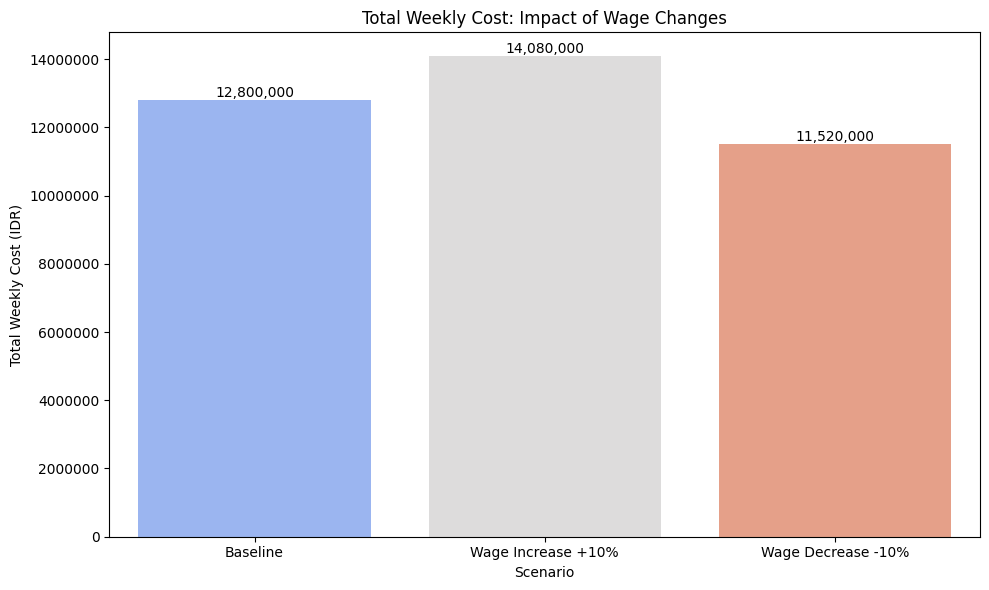

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data extracted from previous execution outputs for wage changes
costs_wage_changes = {
    'Scenario': [
        'Baseline',
        'Wage Increase +10%',
        'Wage Decrease -10%'
    ],
    'Cost (IDR)': [
        12800000,   # Baseline
        14080000,   # Wage Increase +10%
        11520000    # Wage Decrease -10%
    ]
}

df_wage_costs = pd.DataFrame(costs_wage_changes)

plt.figure(figsize=(10, 6))
sns.barplot(x='Scenario', y='Cost (IDR)', data=df_wage_costs, palette='coolwarm')
plt.title('Total Weekly Cost: Impact of Wage Changes')
plt.xlabel('Scenario')
plt.ylabel('Total Weekly Cost (IDR)')
plt.ticklabel_format(style='plain', axis='y') # Prevent scientific notation on y-axis

# Add cost labels on top of the bars
for index, row in df_wage_costs.iterrows():
    plt.text(index, row['Cost (IDR)'], f'{int(row["Cost (IDR)"]):,}', color='black', ha="center", va="bottom")

plt.tight_layout()
plt.show()